<a href="https://colab.research.google.com/github/Martin09/DeepSEM/blob/master/nanowire_yield/3_nw_yield_yield_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detectron2 Beginner's Tutorial

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

Welcome to detectron2! This is the official colab tutorial of detectron2. Here, we will go through some basics usage of detectron2, including the following:
* Run inference on images or videos, with an existing detectron2 model
* Train a detectron2 model on a new dataset

You can make a copy of this tutorial by "File -> Open in playground mode" and play with it yourself. __DO NOT__ request access to this tutorial.


# Install detectron2

In [0]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
Requirement already up-to-date: torch==1.5 in /usr/local/lib/python3.6/dist-packages (1.5.0+cu101)
Requirement already up-to-date: torchvision==0.6 in /usr/local/lib/python3.6/dist-packages (0.6.0+cu101)
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-6e891x3m
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-6e891x3m
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=267003 sha256=28fa26e41e987233d3470b07c941ca57a86274d96f119102b03dd7a6832a23ca
  Stored in directory: /tmp/pip-ephem-wheel-cache-gifkd5d_/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0


1.5.0+cu101 False
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [0]:
# install detectron2:
!pip install detectron2==0.1.2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html


In [0]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from glob import glob
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [0]:
# # Clone the DeepSEM repository
# !rm -rf DeepSEM
# !git clone https://github.com/Martin09/DeepSEM

# OR

# Load from my GoogleDrive
from google.colab import drive
import sys
drive.mount('/content/gdrive/')
# sys.path.append('/content/gdrive/My Drive/LMSC/MachineLearning/Datasets')
%cd "/content/gdrive/My Drive/LMSC/MachineLearning/Colab"

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/gdrive/My Drive/LMSC/MachineLearning/Colab


## Run trained model on validation image

Load an image and show it

(768, 1024)


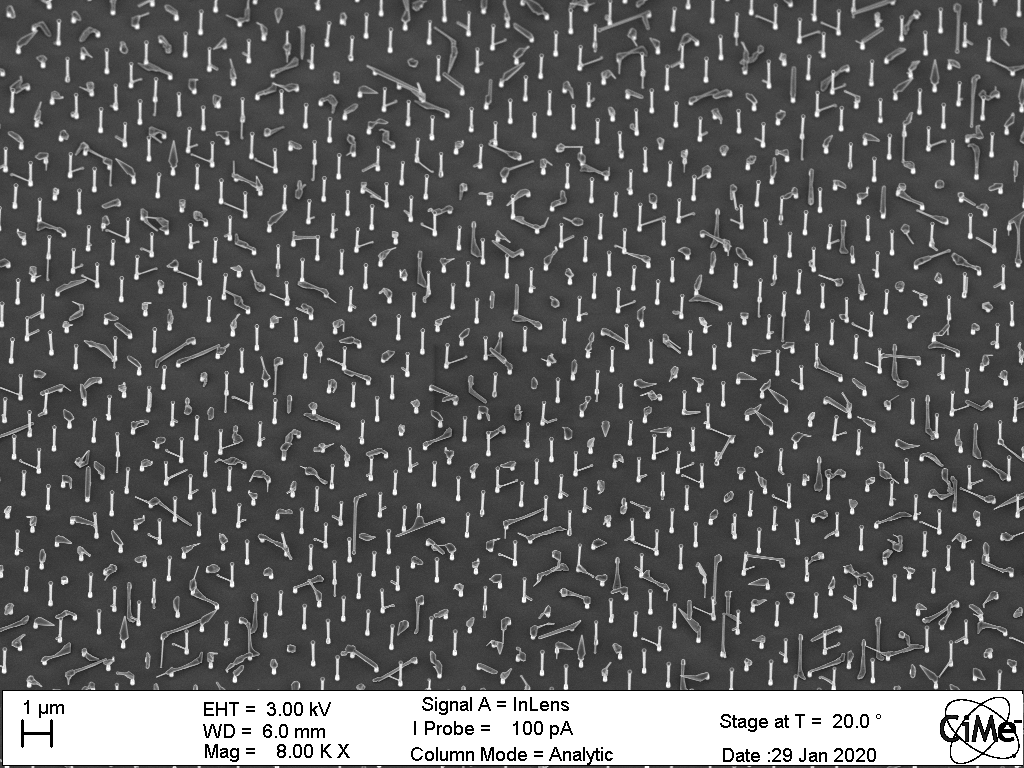

In [0]:
# im = cv2.imread("./DeepSEM/nanowire_yield/datasets/NWs-8kMag-subdivided/135nm_20_cropped_x0_y0.png", cv2.IMREAD_GRAYSCALE)
im = cv2.imread("./DeepSEM/nanowire_yield/inference/NWs-8kMag-rawtiffs/130nm_05.tif", cv2.IMREAD_GRAYSCALE)

print(im.shape)
cv2_imshow(im)

In [0]:
# Model expects an RGB image, so copy the greyscale data into other 2 channels
im_RGB = np.repeat(im[:, :, np.newaxis], 3, axis=2)
print(im_RGB.shape)

(768, 1024, 3)


(688, 1024, 3)


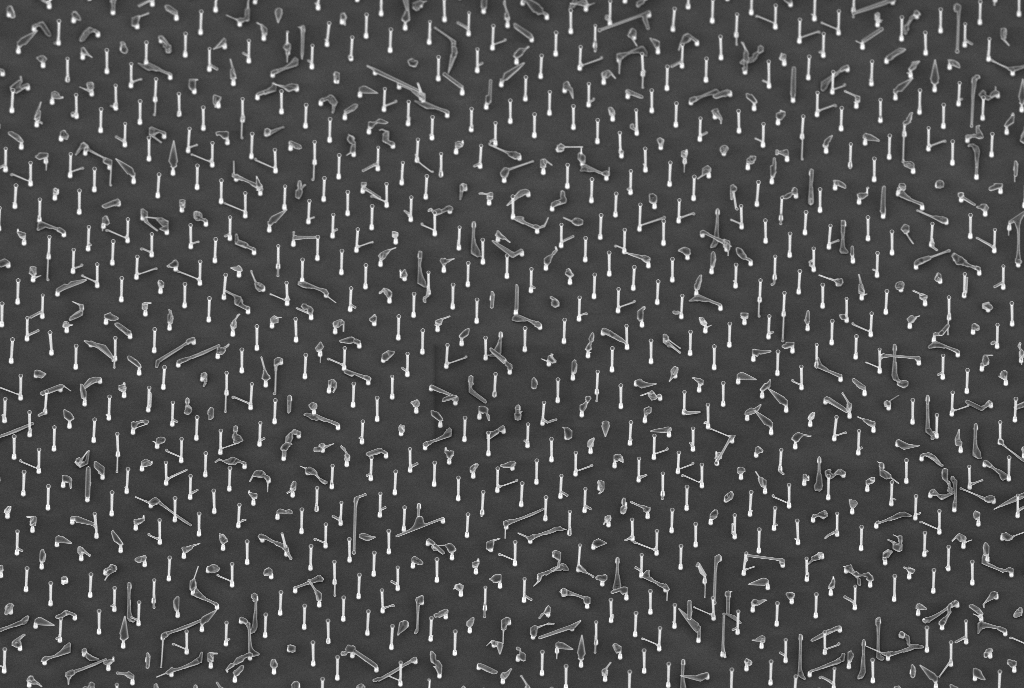

In [0]:
# Trim off the bottom overlay to not confuse the model (if needed)
im_RGB = im_RGB[:688,:,:] 
print(im_RGB.shape)
cv2_imshow(im_RGB)

## Perform inference

Load a previously-saved model.

In [0]:
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog

model_path = './DeepSEM/nanowire_yield/trained_models/nw_yield_it10k_loss0.133.yaml'
# model_path = './DeepSEM/nanowire_yield/trained_models/nw_yield_it99_loss0.93.yaml'

cfg = get_cfg()
cfg.merge_from_file(model_path)
cfg.MODEL.DEVICE = 'cpu'  # CPU is enough for inference

# If we have a lot of objects to detect, need to set higher # of proposals here:
cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 10000
cfg.MODEL.RPN.PRE_NMS_TOPK_TEST = 10000
cfg.TEST.DETECTIONS_PER_IMAGE = 10000

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # Set the testing threshold for this model
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.2     # Non-max supression threshold

# Setting allowed input sizes (avoid scaling)
cfg.INPUT.MIN_SIZE_TEST = 0
cfg.INPUT.MAX_SIZE_TEST = 99999

# A bit of a hacky way to be able to use the DefaultPredictor:
# Register a "fake" dataset to then set the 'thing_classes' metadata
# (there is probably a better way to do this...)
cfg.DATASETS.TEST = ('placeholder')
DatasetCatalog.clear()
DatasetCatalog.register("placeholder", lambda _: None)
MetadataCatalog.get("placeholder").set(thing_classes=["nw","parasitic","nanospade"])

Metadata(name='placeholder', thing_classes=['nw', 'parasitic', 'nanospade'])

Create a predictor, and run the predictor on the image to generate the outputs.

In [0]:
predictor = DefaultPredictor(cfg)
outputs = predictor(im_RGB)
print('Number of detected objects = {}'.format(len(outputs["instances"])))

Number of detected objects = 928


In [0]:
# Verify outputs manually
# outputs["instances"].pred_classes
# outputs["instances"].pred_boxes
# outputs["instances"].scores

Now we can visualize the output of the model.

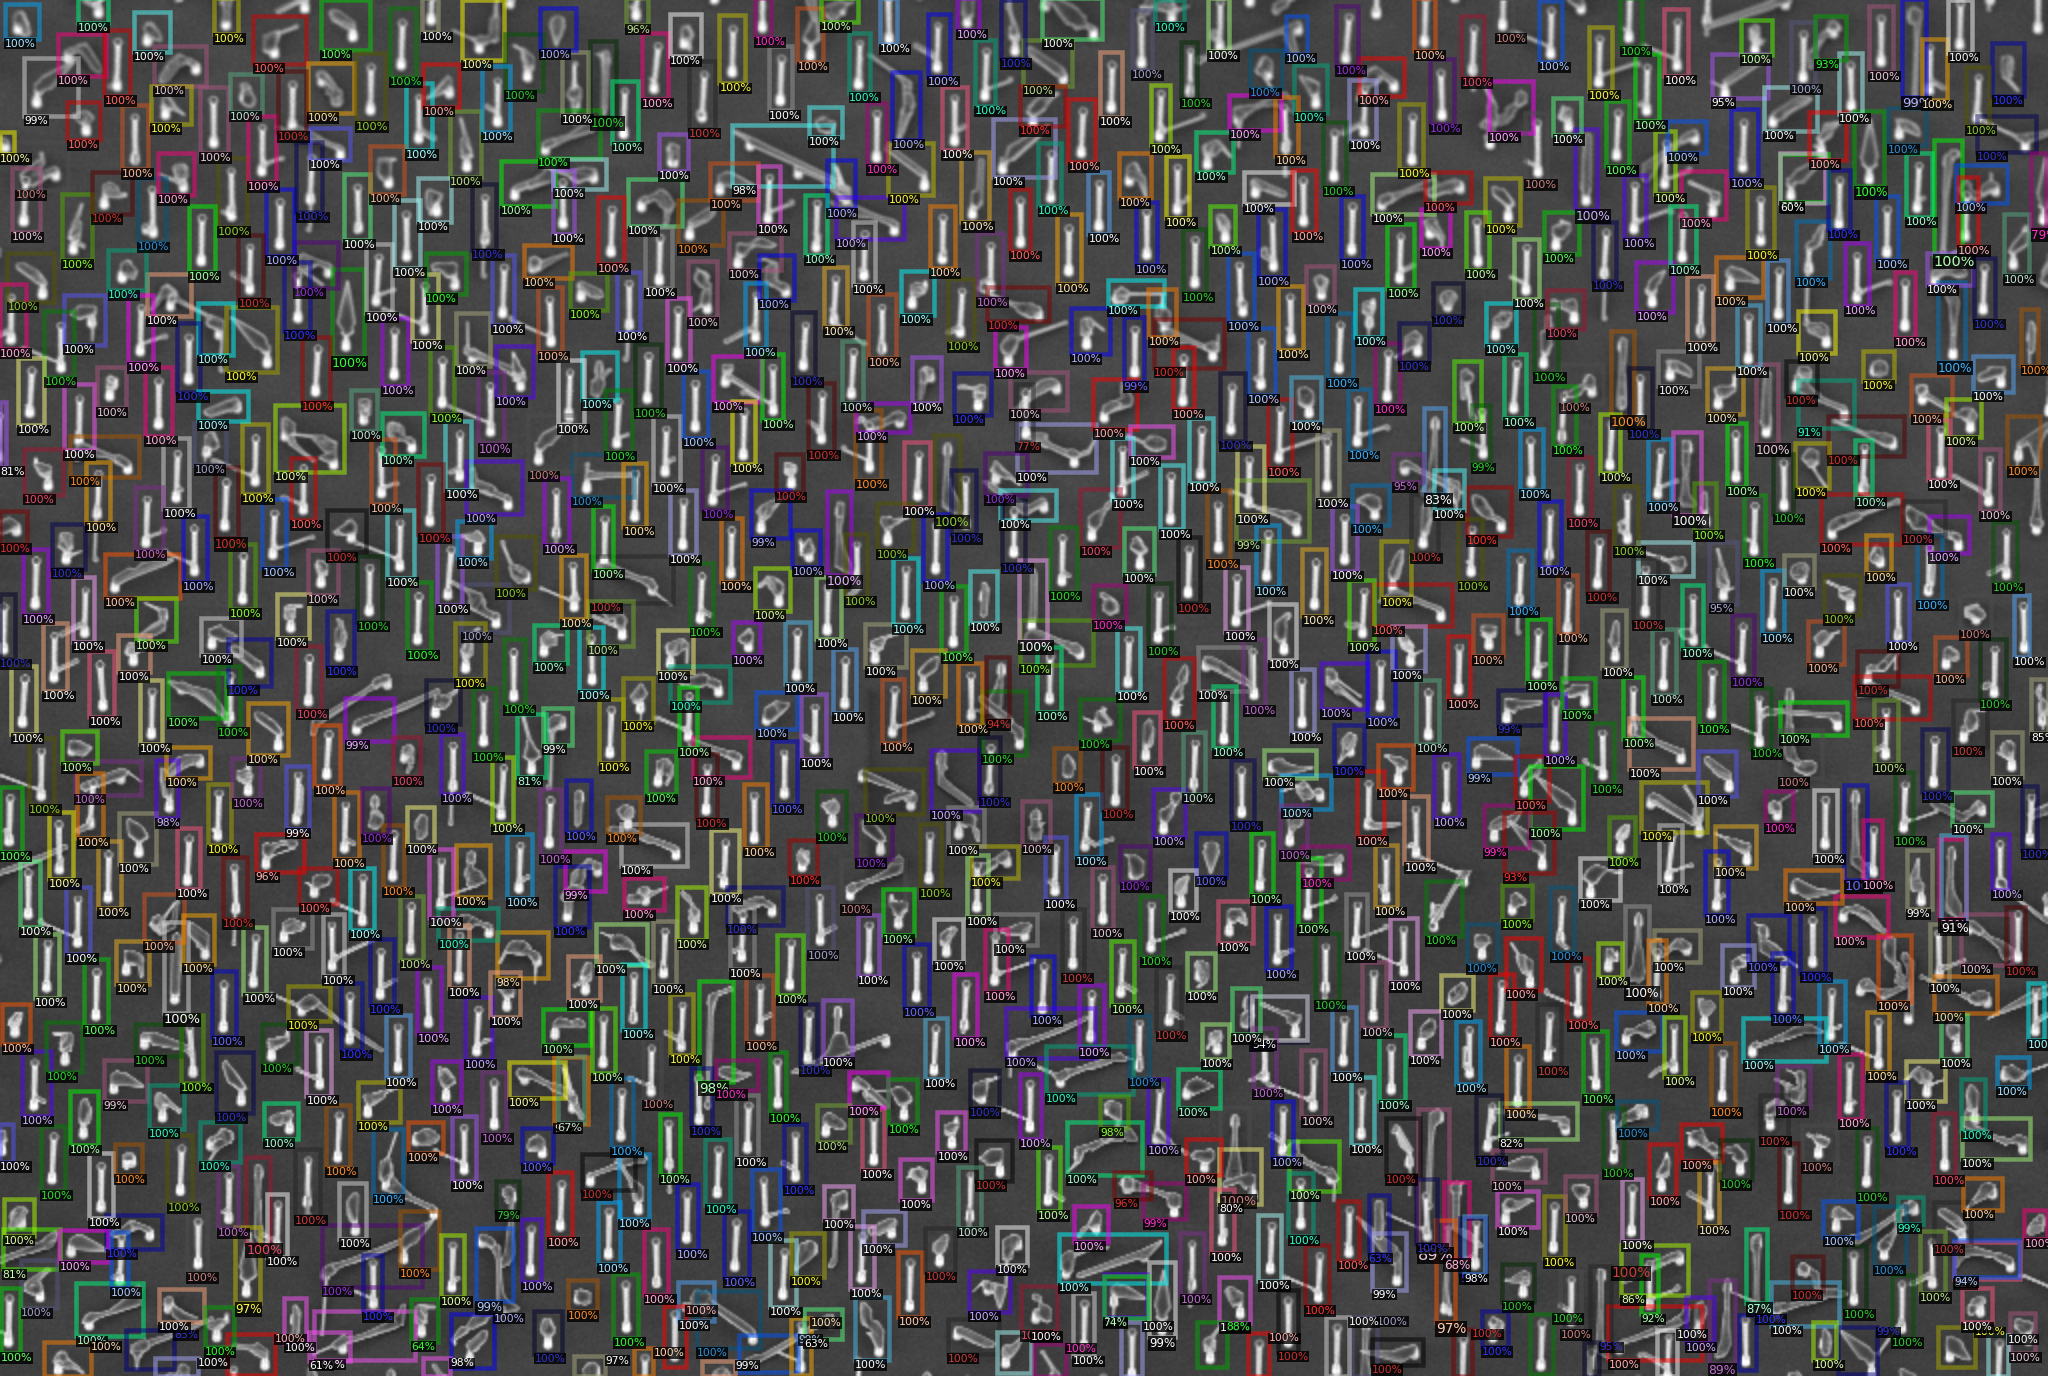

In [0]:
# We can use Visualizer to draw the predictions on the image.
v = Visualizer(im_RGB[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=2.0)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

# Post-processing

Massage the output a bit to get it into a single numpy array for easy filtering.

In [0]:
cl = np.array(outputs["instances"].pred_classes.cpu())  # Classes
s = np.array(outputs["instances"].scores.cpu()) # Prediction scores
b =  np.array([x.numpy() for x in outputs["instances"].pred_boxes])  # Bounding boxes
c = np.array(outputs["instances"].pred_boxes.get_centers())  # Bounding box centres
predictions = np.column_stack([cl,s,b,c])

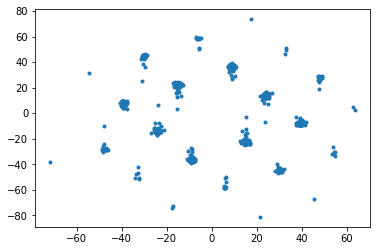

In [0]:
from matplotlib import pyplot as plt

# Select only NW predictions
predictions = predictions[predictions[:,0]==0]

# Extract NW bounding box centres
centres = predictions[:,-2:]
C = centres  # Tensor variable notation to use later in matrix calculations

# Loop over NW bounding box centres. For each one, find vector for 3 closest NWs
vectors = []
for p in centres:

    # Build a tensor as large as centres tensor
    p = p[np.newaxis]
    P = np.repeat(p, len(C), axis=0)

    # Calculate distance to all other NWs in a vectorized way
    D = np.linalg.norm(C - P, axis=1)
    n = 3 # Number of minimum distances to extract
    i_min = np.argsort(-D)[-1-n:-1]  # Find "n" minimum distances
    V = C[i_min] - np.repeat(p, n, axis=0)
    vectors.extend(V.squeeze().tolist())

vectors = np.array(vectors)
lengths = np.linalg.norm(vectors, axis=1)

plt.plot(vectors[:,0], vectors[:,1],'.')

Above we have a plot of the nanowire grid from which we can now extract the grid vectors.

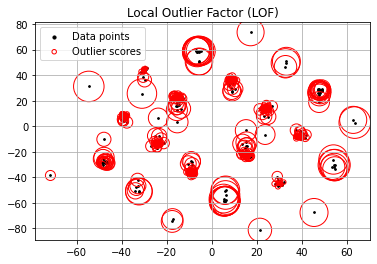

In [0]:
from sklearn.neighbors import LocalOutlierFactor

X = vectors

# Fit model for local outlier function
clf = LocalOutlierFactor(n_neighbors=25, contamination=0.1, algorithm='auto')
_ = clf.fit_predict(X)  # Make prediction of outliers
X_scores = clf.negative_outlier_factor_  # Get outlier scores (lower score means more of an outlier)

# Plot outlier analysis
plt.title("Local Outlier Factor (LOF)")
plt.scatter(X[:, 0], X[:, 1], color='k', s=3., label='Data points')

radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(X[:, 0], X[:, 1], s=1000 * radius, edgecolors='r',
            facecolors='none', label='Outlier scores')
plt.grid()
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]

Can now filter the points based on their "outlier scores" to get only the grid vectors that we are interested in.

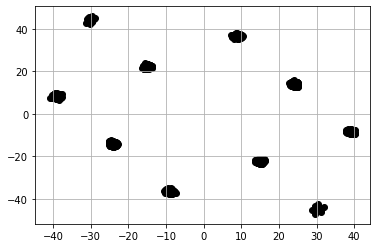

In [0]:
X_filt = X[X_scores[:] > -1.5,:]  # Filter points based on outlier scores
plt.scatter(X_filt[:, 0], X_filt[:, 1], color='k')
plt.grid()

We have many points now, we just need to find those that correspond to the unit vectors (shortest). So apply an additional step of filtering and extract only the shortest vectors by plotting a histogram.

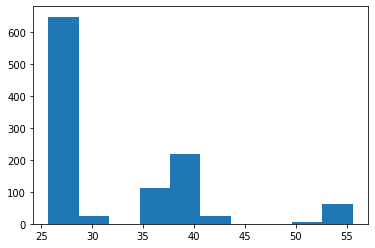

In [0]:
D = np.linalg.norm(X_filt,axis=1)
n, bins, _ = plt.hist(D)

i_max = np.argsort(n)[-1]  # Find index of maximum
i_filt = list(n).index(0,i_max)  # After this maximum, find first index where N=0

# Filter out all vectors that are longer than this
D_f = bins[i_filt]
X_filt2 = X_filt[np.linalg.norm(X_filt,axis=1) < D_f]

Apply k-means clustering to the filtered list and extract the remaining four points.

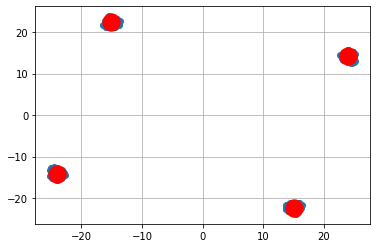

In [0]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X_filt2)
plt.scatter(X_filt2[:,0], X_filt2[:,1])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.grid()

Convert those 4 points into the two grid vectors that we need.




In [0]:
tmp_pos = [x for x in kmeans.cluster_centers_ if x[0] > 0 and x[1] > 0][0]
tmp_neg = [x for x in kmeans.cluster_centers_ if x[0] < 0 and x[1] < 0][0]
v1 = np.mean([tmp_pos,-tmp_neg],axis=0)

tmp_pos = [x for x in kmeans.cluster_centers_ if x[0] > 0 and x[1] < 0][0]
tmp_neg = [x for x in kmeans.cluster_centers_ if x[0] < 0 and x[1] > 0][0]
v2 = np.mean([tmp_pos,-tmp_neg],axis=0)

# Vectors v1 and v2 now characterize the grid on which the NWs appear
print(f'Vector 1 = {v1}')
print(f'Vector 2 = {v2}')

Vector 1 = [24.02114846 14.14069741]
Vector 2 = [ 15.05400773 -22.39258748]


No we can use these vectors to generate an array of points where we expect to find the NWs.

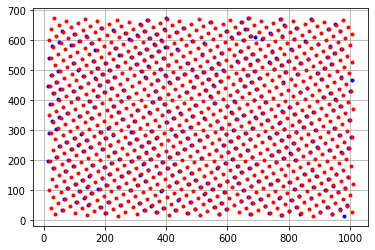

In [0]:
# Determine how many grid points (roughly) we need to generate to cover this image
image_width, image_height = im_RGB.shape[:2]
l_min = np.min([np.linalg.norm(v1),np.linalg.norm(v2)])
n = int(np.max([image_height,image_width])/l_min)+1 # Round up, to be safe

# Generate array of grid points where to look for NWs
grid_pts = np.array(np.meshgrid(range(-n,n), range(-n,n))).T.reshape(-1,2)  # Create standard grid
V = np.column_stack([v1,v2])
grid_pts = grid_pts.dot(V.T) # Coordinate transformation
grid_pts += np.array([image_width, image_height])/2 # Shift grid to centre of image

# Remove points outside image
b = np.max([np.linalg.norm(v1),np.linalg.norm(v2)])*0.5 # Area around edges of image
grid_pts = np.array([[x,y] for x,y in grid_pts if (0+b<x<image_height-b) and (0+b<y<image_width-b)])
centres = np.array([[x,y] for x,y in centres if (0+b<x<image_height-b) and (0+b<y<image_width-b)])

# Plot both the grid points and the NW centres together to see if they more or less match
plt.plot(centres[:,0],centres[:,1],'b.')
plt.plot(grid_pts[:,0],grid_pts[:,1],'r.')
plt.grid()

Now we have the grid points, but they are not necessarily aligned well to the NW positions, as seen above. Therefore perform some optimization with scipy to minimize the error between the grid points and the NW points.

In [0]:
import numpy as np
from scipy.optimize import leastsq, minimize

def get_grid(grid_pts, shift):
    return grid_pts + np.array(shift)

def get_mean_distance(nw_pts, g_pts):
    err_vector = np.array([0.,0.])
    for p in nw_pts:
        D = np.linalg.norm(g_pts - p, axis=1)
        err_vector += (g_pts[np.argmin(D)] - p)**2
        # err_vector += (g_pts[np.argmin(D)] - p)
    return np.linalg.norm(err_vector)

def err_func(params, nw_centres, grid_pts):
    shifted_grid = get_grid(grid_pts, params)
    err = get_mean_distance(nw_centres, shifted_grid)
    return err

# Find the optimal shift of the grid to minimize error vector for all points
out = minimize(err_func, 
               x0=(4, 5),
               method='Nelder-Mead', 
               args=(centres, grid_pts))    
out

 final_simplex: (array([[-2.7840365 ,  0.22684042],
       [-2.7840999 ,  0.22689519],
       [-2.7840418 ,  0.226939  ]]), array([1494.8612501 , 1494.86125024, 1494.86125044]))
           fun: 1494.861250104315
       message: 'Optimization terminated successfully.'
          nfev: 90
           nit: 48
        status: 0
       success: True
             x: array([-2.7840365 ,  0.22684042])

out.x gives us the optimized shift that minimizes the error.

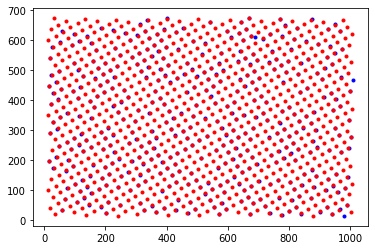

In [0]:
# Apply the optimized shift to the grid and plot it
new_grid_pts = grid_pts + out.x
plt.plot(centres[:,0],centres[:,1],'b.')
plt.plot(new_grid_pts[:,0],new_grid_pts[:,1],'r.')

Now that the point grid and nanowire grid are aligned, can now perform the yield analysis. This is easiest if we transform the coordinates into the grid vector space. This is just the inverse of the transformation matrix that we already created to generate the grid points.

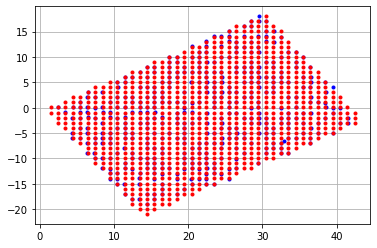

In [0]:
V_inv = np.linalg.inv(V) # Inverse coordinate transformation matrix

# Bring the NW center points back into grid vector space
centres_vcoords = centres.dot(V_inv.T)
grid_pts_vcoords = new_grid_pts.dot(V_inv.T)

# Plot them in grid vector space
plt.plot(centres_vcoords[:,0], centres_vcoords[:,1],'b.')
plt.plot(grid_pts_vcoords[:,0],grid_pts_vcoords[:,1],'r.')
plt.grid()

Now we can loop over each grid point and look for a corresponding NW that is within that is <0.5 grid vector units.

In [0]:
has_nw_list = [] # Add here if there is a NW in this position or not
patch_list = [] # Add here the coordinates of the patches for later plotting on top of the image
# Loop over all grid points
for pt in grid_pts_vcoords:
    # Calculate distances from this point to all NW centres
    D = np.linalg.norm(centres_vcoords - pt, axis=1)

    # Find the closest NW centre
    closest_nw = centres_vcoords[np.argmin(D)]
    
    # Is this NW within the current grid point unit cell?
    has_nw = pt[0] - 0.5 < closest_nw[0] < pt[0] + 0.5 and pt[1] - 0.5 < closest_nw[1] < pt[1] + 0.5
    has_nw_list.append(has_nw)

    # Save the coordinates of this grid point unit cell for later plotting
    patch = np.array([pt+[0.5,0.5],pt+[-0.5,0.5],pt+[-0.5,-0.5],pt+[0.5,-0.5]])
    patch_list.append(patch)

patch_list = np.array(patch_list)

Now we have enough information to calculate NW yield

In [0]:
nw_yield = has_nw_list.count(True)/len(has_nw_list)
print("NW yield is {:.0f}/{:.0f} = {:.0f}%!".format(has_nw_list.count(True), len(has_nw_list), nw_yield*100))

NW yield is 413/875 = 47%!


To visualize this, transform the patches back into original image coordinates and plot the patches based on if there was a NW found in them or not.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  if sys.path[0] == '':


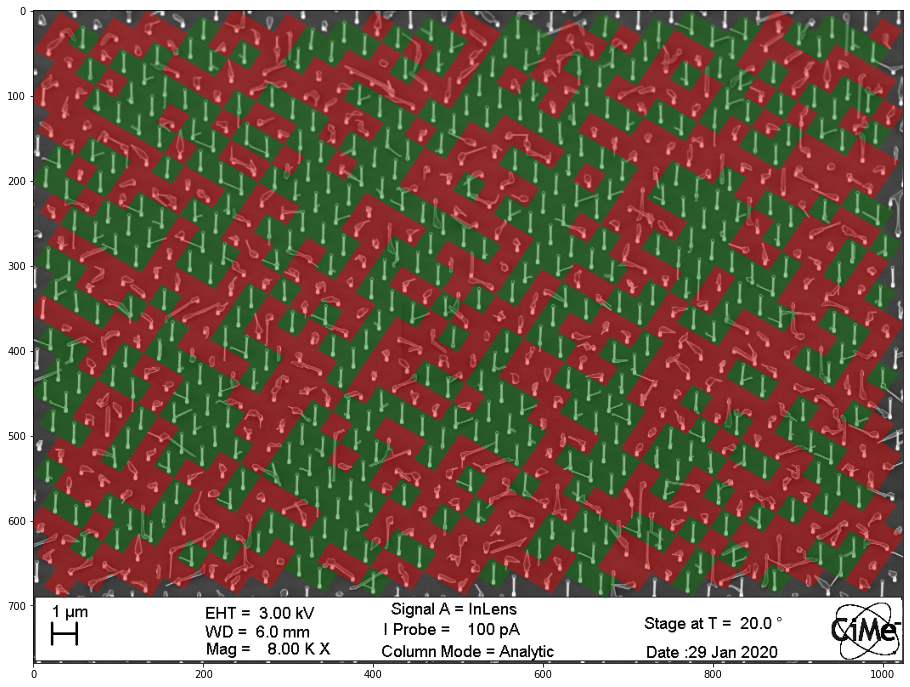

In [0]:
# Transform from grid vector space back into image coordinate space
patches_imgcoords = patch_list.reshape([-1,2]).dot(V.T).reshape([-1,4,2])

# Plot the image
plt.figure(figsize=(20,12))
plt.imshow(im, cmap='gray', vmin=0, vmax=255)
current_axis = plt.gca()

# Plot semi-transparent patches on top
colors = ['r', 'g']
for i, patch in enumerate(patches_imgcoords):
    color = colors[has_nw_list[i]]
    current_axis.add_patch(plt.Polygon(patch, color=color, fill=True, linewidth=0, alpha = 0.4))  